### Your name:

<pre> Isaac Aktam</pre>

### Collaborators:

<pre> Ashish Gupta, Konrad Korzeniewski</pre>


# Assignment for Module 4: Clustering

## Description

In this assignment you will study the electric demand (power) of clients in Portugal, during 2013 and 2014.

The data$^1$ available contains 370 time series, corresponding to the electric demand$^2$ for 370 clients, between 2011 and 2014. 

In this guided exercise you will use clustering techniques to understand the typical behaviour during 2013-2014.

#### 1. Data:
https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014#

#### 2. Electric Demand:
http://www.think-energy.net/KWvsKWH.htm


## Data Preparation

Start by downloading the data to a local directory and modify the "pathToFile" and "fileName" variables, if needed

In [44]:
pathToFile = r"/home/isaac/Fundamentals_of_Data_Science_Certificate/3253 - Machine_Learning/Assignments/"
fileName = 'LD2011_2014.txt'

In [45]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import random
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
random.seed(42)

In [46]:
# Replace "," by ".", otherwise the numbers will be in the form 2,3445 instead of 2.3445
import fileinput

with fileinput.FileInput(pathToFile+fileName, inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(",", "."), end='')

In [47]:
# Create dataframe
import pandas as pd
data = pd.read_csv(pathToFile+fileName, sep=";", index_col=0)

### Quick data inspection

In [48]:
data.head(2)

MT_001  MT_002  MT_003  MT_004  MT_005  MT_006  MT_007  \
2011-01-01 00:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2011-01-01 00:30:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

                     MT_008  MT_009  MT_010   ...    MT_361  MT_362  MT_363  \
2011-01-01 00:15:00     0.0     0.0     0.0   ...       0.0     0.0     0.0   
2011-01-01 00:30:00     0.0     0.0     0.0   ...       0.0     0.0     0.0   

                     MT_364  MT_365  MT_366  MT_367  MT_368  MT_369  MT_370  
2011-01-01 00:15:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0  
2011-01-01 00:30:00     0.0     0.0     0.0     0.0     0.0     0.0     0.0  

[2 rows x 370 columns]

In [49]:
data.tail(2)

MT_001     MT_002    MT_003      MT_004     MT_005  \
2014-12-31 23:45:00  1.269036  21.337127  1.737619  166.666667  85.365854   
2015-01-01 00:00:00  2.538071  19.914651  1.737619  178.861789  84.146341   

                         MT_006    MT_007      MT_008     MT_009     MT_010  \
2014-12-31 23:45:00  285.714286  10.17524  225.589226  64.685315  72.043011   
2015-01-01 00:00:00  279.761905  10.17524  249.158249  62.937063  69.892473   

                        ...           MT_361   MT_362       MT_363  \
2014-12-31 23:45:00     ...       246.252677  28000.0  1443.037975   
2015-01-01 00:00:00     ...       188.436831  27800.0  1409.282700   

                         MT_364     MT_365    MT_366      MT_367      MT_368  \
2014-12-31 23:45:00  909.090909  26.075619  4.095963  664.618086  146.911519   
2015-01-01 00:00:00  954.545455  27.379400  4.095963  628.621598  131.886477   

                         MT_369       MT_370  
2014-12-31 23:45:00  646.627566  6540.540541  
2015-01-01 00:00:00  673.020528  7135.135135  

[2 rows x 370 columns]

In [50]:
data.shape

(140256, 370)

#### As can be seen, the dataframe contains a row for each interval of 15 minutes between Jan 1, 2011 to Dec 31 2014. There are 370 columns corresponding 370 clients. The dataframe is indexed by the timestamp.

Since the frequency is 15 minutes, each day provides $24\times 4 = 96$ datapoints, which multiplied by 365 days and 4 years (plus 1 day in Feb 29, 2012) gives: $96 \times 365 \times 4 + 96 = 140256$, as observed in data.shape

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140256 entries, 2011-01-01 00:15:00 to 2015-01-01 00:00:00
Columns: 370 entries, MT_001 to MT_370
dtypes: float64(370)
memory usage: 397.0+ MB


In [52]:
data.describe()

MT_001         MT_002         MT_003         MT_004  \
count  140256.000000  140256.000000  140256.000000  140256.000000   
mean        3.970785      20.768480       2.918308      82.184490   
std         5.983965      13.272415      11.014456      58.248392   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       2.844950       0.000000      36.585366   
50%         1.269036      24.893314       1.737619      87.398374   
75%         2.538071      29.871977       1.737619     115.853659   
max        48.223350     115.220484     151.172893     321.138211   

              MT_005         MT_006         MT_007         MT_008  \
count  140256.000000  140256.000000  140256.000000  140256.000000   
mean       37.240309     141.227385       4.521338     191.401476   
std        26.461327      98.439984       6.485684     121.981187   
min         0.000000       0.000000       0.000000       0.000000   
25%        15.853659      71.428571       0.565291     111.111111   
50%        39.024390     157.738095       2.826456     222.222222   
75%        54.878049     205.357143       4.522329     279.461279   
max       150.000000     535.714286      44.657999     552.188552   

              MT_009         MT_010      ...               MT_361  \
count  140256.000000  140256.000000      ...        140256.000000   
mean       39.975354      42.205152      ...           218.213701   
std        29.814595      33.401251      ...           204.833532   
min         0.000000       0.000000      ...             0.000000   
25%        13.986014       9.677419      ...             5.710207   
50%        40.209790      40.860215      ...           131.334761   
75%        57.692308      61.290323      ...           403.283369   
max       157.342657     198.924731      ...           852.962170   

              MT_362         MT_363         MT_364         MT_365  \
count  140256.000000  140256.000000  140256.000000  140256.000000   
mean    37607.987537    1887.427366    2940.031734      65.413150   
std     38691.954832    1801.486488    2732.251967      65.007818   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000      13.037810   
50%     24100.000000    1050.632911    2136.363636      31.290743   
75%     54800.000000    3312.236287    5363.636364     108.213820   
max    192800.000000    7751.054852   12386.363636     335.071708   

              MT_366         MT_367         MT_368         MT_369  \
count  140256.000000  140256.000000  140256.000000  140256.000000   
mean        9.269709     424.262904      94.704717     625.251734   
std        10.016782     274.337122      80.297301     380.656042   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000      30.050083      83.944282   
50%         7.021650     525.899912      76.794658     758.064516   
75%        11.702750     627.743635     151.919866     875.366569   
max        60.269163    1138.718174     362.270451    1549.120235   

              MT_370  
count  140256.000000  
mean     8722.355145  
std      9195.155777  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%     17783.783784  
max     30918.918919  

[8 rows x 370 columns]

### Plot the 2 days of 2012 for the first 2 clients

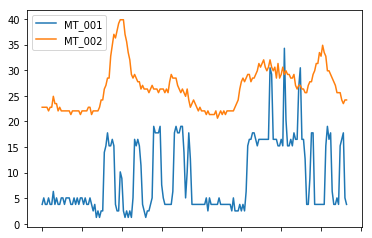

In [53]:
data_example = data.loc['2012-01-01 00:15:00':'2012-01-03 00:00:00'][['MT_001','MT_002']]
data_example.plot()
plt.show()

#### We quickly note that the main difference between the curves is the level (also seen on the means in df.describe()), so we know we will have to somehow normalize the curves, in order for the clustering technique to capture the behaviour of the consumption throughout the day, rather than the overall level.

### Data for the analysis

We focus on 2013 and 2014 because these are the years with lower number of clients having zero demand

In [54]:
data2011 = data.loc['2011-01-01 00:15:00':'2012-01-01 00:00:00']
data2012 = data.loc['2012-01-01 00:15:00':'2013-01-01 00:00:00']
data2013 = data.loc['2013-01-01 00:15:00':'2014-01-01 00:00:00']
data2014 = data.loc['2014-01-01 00:15:00':'2015-01-01 00:00:00']

In [55]:
# Check number of days
print(data2011.shape[0]/96)
print(data2012.shape[0]/96)
print(data2013.shape[0]/96)
print(data2014.shape[0]/96)

365.0
366.0
365.0
365.0


In [56]:
# See number of clients with 0 demand per year
print(sum(data2011.mean()==0))
print(sum(data2012.mean()==0))
print(sum(data2013.mean()==0))
print(sum(data2014.mean()==0))

210
37
21
1


In [57]:
clients = data2011.columns
clients_no_demand = clients[data2013.mean()==0] # clients with 0 demand
data_13_14 = data2013.append(data2014) # appending 2013 and 2014
data_13_14 = data_13_14.drop(clients_no_demand, axis=1) # drop clients with 0 demand
print(data_13_14.shape)
print(sum(data_13_14.mean()==0)) # check that there are no clients with 0 demand

(70080, 349)
0


## Getting average curves per client

In [58]:
data = data_13_14.copy() # weekdays weekends, data2011, data2012, data2013, data2014

In [59]:
data['hour'] = data.index.map(lambda x: x[11:])

In [60]:
data.head(3)

MT_001     MT_002    MT_003      MT_004     MT_005  \
2013-01-01 00:15:00  2.538071  22.759602  2.606429  138.211382  63.414634   
2013-01-01 00:30:00  1.269036  22.759602  2.606429  138.211382  63.414634   
2013-01-01 00:45:00  2.538071  22.759602  2.606429  134.146341  60.975610   

                         MT_006    MT_007      MT_008     MT_009     MT_010  \
2013-01-01 00:15:00  255.952381  4.522329  239.057239  57.692308  78.494624   
2013-01-01 00:30:00  264.880952  5.652911  228.956229  57.692308  76.344086   
2013-01-01 00:45:00  250.000000  5.652911  239.057239  54.195804  76.344086   

                       ...      MT_362      MT_363       MT_364     MT_365  \
2013-01-01 00:15:00    ...     22300.0  886.075949  1000.000000  16.949153   
2013-01-01 00:30:00    ...     21000.0  864.978903   909.090909  18.252934   
2013-01-01 00:45:00    ...     18200.0  860.759494   840.909091  16.949153   

                       MT_366      MT_367     MT_368      MT_369       MT_370  \
2013-01-01 00:15:00  6.436513  616.330114  76.794658  731.671554  8086.486486   
2013-01-01 00:30:00  3.510825  564.530290  76.794658  727.272727  8086.486486   
2013-01-01 00:45:00  5.851375  590.869183  68.447412  730.205279  7848.648649   

                         hour  
2013-01-01 00:15:00  00:15:00  
2013-01-01 00:30:00  00:30:00  
2013-01-01 00:45:00  00:45:00  

[3 rows x 350 columns]

### Getting average curves per client

In [61]:
datagrouped = data.groupby("hour")
average_curves = datagrouped.agg("mean")
average_curves.shape 

(96, 349)

#### The dataframe average_curves contains the 349 typical weekday electric demands

#### We now divide each curve by its mean, so that all curves have mean 1

In [62]:
average_curves_norm = average_curves/(average_curves.mean())

#### Plot the first 2 and last 2 clients

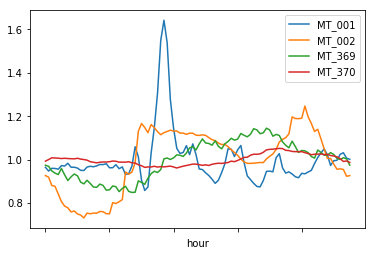

In [63]:
average_curves_norm[['MT_001','MT_002','MT_369','MT_370']].plot()
plt.show()

## Clustering Analysis on the average normizalied curves

In [64]:
X = average_curves_norm.copy()
X = np.array(X.T) # put it on the right format

In [65]:
X.shape

(349, 96)

## Exercise 1:

a. Using the functions described in Module 2, determine what a convenient number of clusters based on _intertia_ and based on _silhouette_. Justify your choice

b. Make a plot for each cluster, that includes:
    - The number of clients in the cluster (you can put this in the title of the plot)
    - All the curves in the cluster
    - The curve corresponding to the centroid of the cluster (make this curve thicker to distinguish it from the individual curves)
    
You can do 2 separate plots for each cluster if you prefer (one for the individual curves, one for the centroid)

In [66]:
############################################################################################
### Part 1.a, create inertia and silhouette to determine a convenient number of clusters ###
############################################################################################

# Inertia

def getInertia(X,kmeans):
    ''' This function returns the exact same value as the attribute inertia_ of kmeans'''
    inertia = 0
    for J in range(len(X)):
        inertia = inertia + np.linalg.norm(X[J] - kmeans.cluster_centers_[kmeans.labels_[J]])**2
    return inertia

# Inertia 2

def getInertia2(X,kmeans):
    ''' This function is analogous to getInertia, but with respect to the 2nd closest center, rather than closest one'''
    inertia2 = 0
    for J in range(len(X)):
        L = min(1,len(kmeans.cluster_centers_)-1) # this is just for the case where there is only 1 cluster at all
        dist_to_center = sorted([np.linalg.norm(X[J] - z)**2 for z in kmeans.cluster_centers_])[L]
        inertia2 = inertia2 + dist_to_center
    return inertia2   

# Computing 3 performance measures for a range of values of  k

inertias_1 = []
inertias_2 = []
silhouette_avgs = []
max_K = 15
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)    
    inertias_1 = inertias_1 + [kmeans.inertia_]
    inertias_2 = inertias_2 + [getInertia2(X,kmeans)]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]

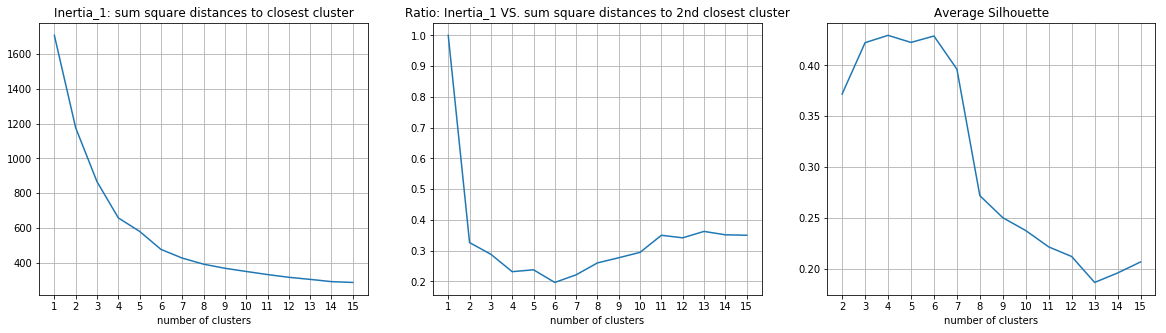

In [67]:
# Plotting performances

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(1,max_K+1),inertias_1)
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()
    
plt.subplot(1,3,2)    
plt.title("Ratio: Inertia_1 VS. sum square distances to 2nd closest cluster")
plt.plot(np.arange(1,max_K+1),np.array(inertias_1)/np.array(inertias_2))
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.subplot(1,3,3)  
plt.title("Average Silhouette")
plt.plot(np.arange(2,max_K+1), silhouette_avgs)
plt.xticks(np.arange(2,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.show()

In the first case (looking at inertias) what we are looking for is an "elbow" in the graph. In this case, it is located around $k=6$. Notice that we do not choose the value of $k$ with the smallest value since the inertia keeps decreasing as $k$ increase. This is by construction of the quantity _inertia_. 

When looking at the ration between inertia_1 and inertia_2, one looks for a minimum value, which in this case corresponds with $k=6$ as well.

The silhouette gives higher values for best clusterings, so what we look for is a maximum, which happens again at $k=6$.

In [68]:
##########################################################################################################################################
### Part 1.b, Make a plot for each cluster, that includes:                                                                             ###
###    - The number of clients in the cluster (you can put this in the title of the plot)                                              ###
###    - All the curves in the cluster                                                                                                 ###
###    - The curve corresponding to the centroid of the cluster (make this curve thicker to distinguish it from the individual curves) ###
##########################################################################################################################################

trueK = 6

kmeans = KMeans(n_clusters=trueK, random_state=0).fit(X)

centroids = kmeans.cluster_centers_

#centroids = centroids / np.mean(centroids) # Divide each centroid by its average

# To anser Oleksander's question in regards to the division of centroids by their mean



centroids.shape

(6, 96)

In [69]:
X.shape

(349, 96)

In [70]:
# Now, let's sort each of the time series with respect to the labels. In the end, once data is sorted, we can 
# get time series AND centroids

kmeans_labels = kmeans.labels_ # numpy array containing labels between 0 and 5. Shape of the array is 349 by 1

# Use the trick from the A1. 

# Generate keys between 0 and 348

keys = [i for i in range(kmeans_labels.shape[0])]

# Create a dictiory with keys between 0 and 348 with 349 customers being the values

time_series_dict = dict(zip(keys, X))

# Create a master_array containing the keys and labels

master_array = np.array([keys, kmeans_labels])

# Now, reorder the master_array w.r.t. the kmeans_labels

list_of_tuples = list(enumerate(master_array[1]))
sorted_list_of_tuples = sorted(list_of_tuples,key=lambda x:x[1])
indexes =[i[0] for i in sorted_list_of_tuples]
master_array = master_array[: , indexes]

# Retreive the ordered labels from the master_array

sorted_labels = master_array[1]

# Retrieve the ordered keys from the master_array

sorted_keys = master_array[0]

# Retrieve the time series data

X_ordered = [time_series_dict[i] for i in sorted_keys] # DONE HERE. Time to slice it all up into 6 parts so that 
                                                       # each part belongs to the centroid
    
X_ordered = np.array(X_ordered)
# Count the occurence of 0 to 5 in sorted_labels

unique, counts = np.unique(sorted_labels, return_counts = True)
label_count_dict = dict(zip(unique, counts)) # {0: 200, 1: 34, 2: 79, 3: 1, 4: 31, 5: 4}

# Time to slice

X_ordered_centroid_0 = X_ordered[0:200,]
X_ordered_centroid_1 = X_ordered[200:234,]
X_ordered_centroid_2 = X_ordered[234:313,]
X_ordered_centroid_3 = X_ordered[313,]
X_ordered_centroid_4 = X_ordered[314:345,]
X_ordered_centroid_5 = X_ordered[345:,]

In [71]:
# Create the x-axis values for time

import datetime

now = datetime.datetime(2013, 2, 9, 0, 00)
end=now+datetime.timedelta(hours=23.75)

l=[]
while now<=end:
    l.append(now)
    now+=datetime.timedelta(minutes=15)

x_axis_time = [t.strftime("%H:%M") for t in l]
x_axis_time = np.array(x_axis_time)
x_axis_time = x_axis_time.reshape([-1, 1])
#print(x_axis_time)  

#x_axis_time.shape

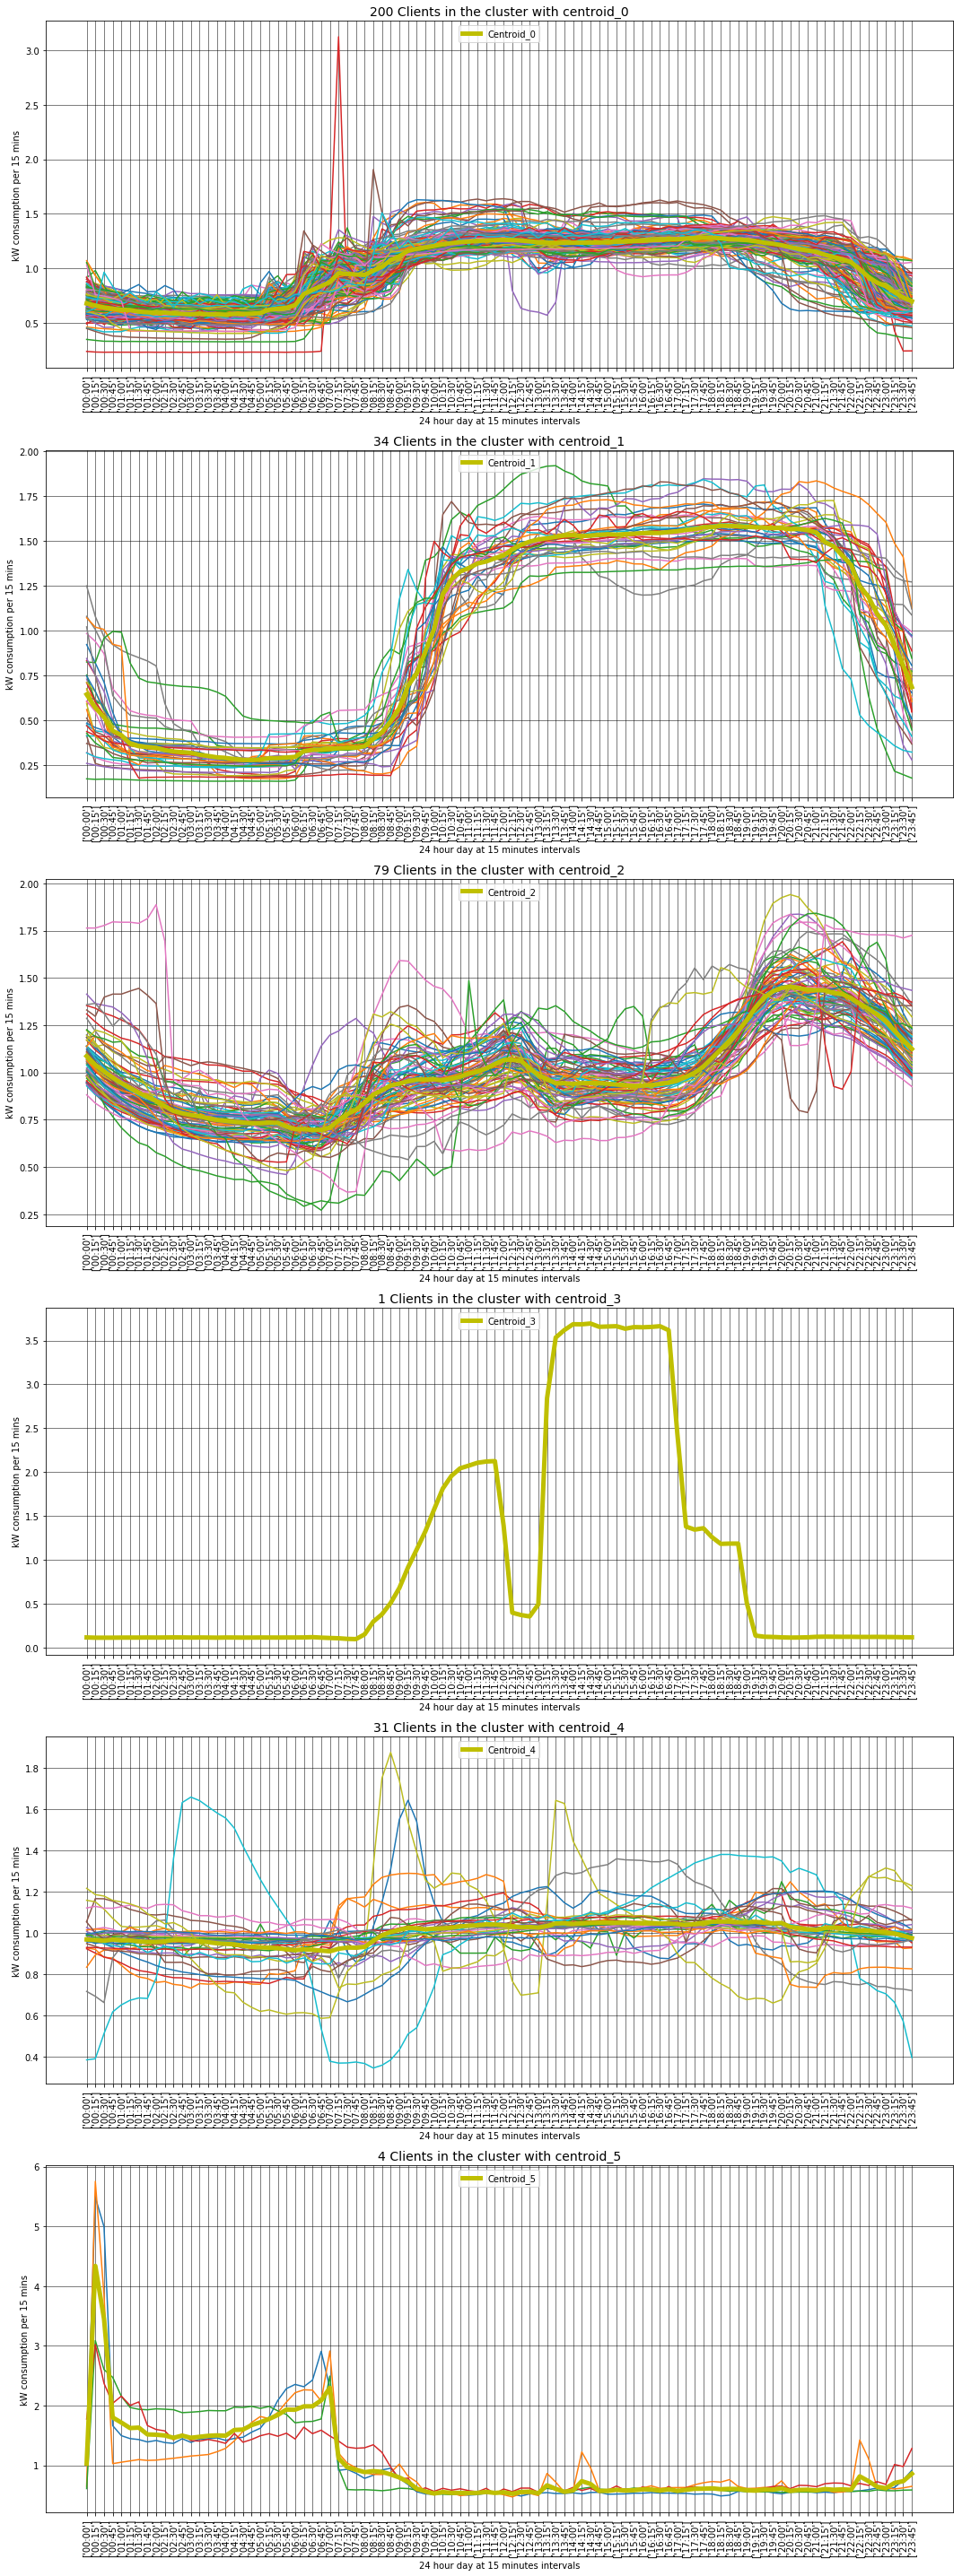

In [72]:
# Time to graph

# plt.figure(figsize=(100,4))
plt.figure(figsize=(15,40))

x_axis = [i for i in range(96)]

plt.plot()

plt.subplot(6,1,1)
#plt.subplot(161)
plt.title("200 Clients in the cluster with centroid_0", fontsize=14)
for i in range(X_ordered_centroid_0.shape[0]):
    plt.plot(X_ordered_centroid_0[i])
plt.plot(centroids[0], linewidth = 5, c = 'y', label = "Centroid_0")
plt.xticks(x_axis, list(x_axis_time), rotation='vertical') # DO NOT DELETE
plt.xlabel("24 hour day at 15 minutes intervals")
plt.ylabel("kW consumption per 15 mins")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.legend(loc="upper center")

plt.subplot(6,1,2)
#plt.subplot(162)
plt.title("34 Clients in the cluster with centroid_1", fontsize=14)
for i in range(X_ordered_centroid_1.shape[0]):
    plt.plot(X_ordered_centroid_1[i])
plt.plot(centroids[1], linewidth = 5, c = 'y', label = "Centroid_1")
plt.xticks(x_axis, list(x_axis_time), rotation='vertical')
plt.xlabel("24 hour day at 15 minutes intervals")
plt.ylabel("kW consumption per 15 mins")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.legend(loc="upper center")

plt.subplot(6,1,3)
#plt.subplot(163)
plt.title("79 Clients in the cluster with centroid_2", fontsize=14)
for i in range(X_ordered_centroid_2.shape[0]):
    plt.plot(X_ordered_centroid_2[i])
plt.plot(centroids[2], linewidth = 5, c = 'y', label = "Centroid_2")
plt.xticks(x_axis, list(x_axis_time), rotation='vertical')
plt.xlabel("24 hour day at 15 minutes intervals")
plt.ylabel("kW consumption per 15 mins")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.legend(loc="upper center")

plt.subplot(6,1,4)
#plt.subplot(164)
plt.title("1 Clients in the cluster with centroid_3", fontsize=14)
for i in range(X_ordered_centroid_3.shape[0]):
    plt.plot(X_ordered_centroid_3[i])
plt.plot(centroids[3], linewidth = 5, c = 'y', label = "Centroid_3")
plt.xticks(x_axis, list(x_axis_time), rotation='vertical')
plt.xlabel("24 hour day at 15 minutes intervals")
plt.ylabel("kW consumption per 15 mins")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.legend(loc="upper center")

plt.subplot(6,1,5)
#plt.subplot(165)
plt.title("31 Clients in the cluster with centroid_4", fontsize=14)
for i in range(X_ordered_centroid_4.shape[0]):
    plt.plot(X_ordered_centroid_4[i])
plt.plot(centroids[4], linewidth = 5, c = 'y', label = "Centroid_4")
plt.xticks(x_axis, list(x_axis_time), rotation='vertical')
plt.xlabel("24 hour day at 15 minutes intervals")
plt.ylabel("kW consumption per 15 mins")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.legend(loc="upper center")

plt.subplot(6,1,6)
#plt.subplot(166)
plt.title("4 Clients in the cluster with centroid_5", fontsize=14)
for i in range(X_ordered_centroid_5.shape[0]):
    plt.plot(X_ordered_centroid_5[i])
plt.plot(centroids[5], linewidth = 5, c = 'y', label = "Centroid_5")
plt.xticks(x_axis, list(x_axis_time), rotation='vertical')
plt.xlabel("24 hour day at 15 minutes intervals")
plt.ylabel("kW consumption per 15 mins")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.legend(loc="upper center")

plt.show()

## Exercises 2

In this exercise you work with the daily curves of 1 single client.

First you create a list of arrays, each array containing a normalized curve for a day. The list contains 730 arrays, one for each of the days of 2013 and 2014.

a. Determine the optimal value for k-means. 

b. What are the clusters that you obtained represent?

In [73]:
# One single client has a record of electricity usage for 730 days with 24 hours each with 15 minutes intervals

client = 'MT_022'
oneClient = data_13_14[client]
X = [] # a list of arrays, each array being a normalized curve for a day
for J in range(2*365):
    X.extend([np.array(oneClient[J*96:(J+1)*96])])#/np.mean(oneClient[J*96:(J+1)*96])]) 
    
# ADD CODE BELOW!

X = X / np.mean(X)

In [74]:
###################################################
### 2.a Determine the optimal value for k-means ###
###################################################

# Run inertia, inertia2, silhouette

def getInertia(X,kmeans):
    ''' This function returns the exact same value as the attribute inertia_ of kmeans'''
    inertia = 0
    for J in range(len(X)):
        inertia = inertia + np.linalg.norm(X[J] - kmeans.cluster_centers_[kmeans.labels_[J]])**2
    return inertia

# Inertia 2

def getInertia2(X,kmeans):
    ''' This function is analogous to getInertia, but with respect to the 2nd closest center, rather than closest one'''
    inertia2 = 0
    for J in range(len(X)):
        L = min(1,len(kmeans.cluster_centers_)-1) # this is just for the case where there is only 1 cluster at all
        dist_to_center = sorted([np.linalg.norm(X[J] - z)**2 for z in kmeans.cluster_centers_])[L]
        inertia2 = inertia2 + dist_to_center
    return inertia2   

# Computing 3 performance measures for a range of values of  k

inertias_1 = []
inertias_2 = []
silhouette_avgs = []
max_K = 15
for k in np.arange(1,max_K+1):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)    
    inertias_1 = inertias_1 + [kmeans.inertia_]
    inertias_2 = inertias_2 + [getInertia2(X,kmeans)]
    if k>1:
        silhouette_avgs = silhouette_avgs + [silhouette_score(X, kmeans.labels_)]

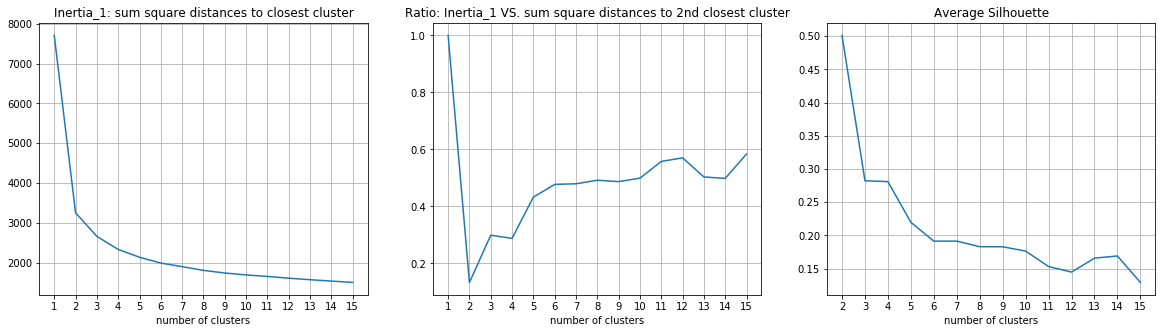

In [75]:
# Plot the inertia, inertia2, silhouette

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
plt.title("Inertia_1: sum square distances to closest cluster")
plt.plot(np.arange(1,max_K+1),inertias_1)
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()
    
plt.subplot(1,3,2)    
plt.title("Ratio: Inertia_1 VS. sum square distances to 2nd closest cluster")
plt.plot(np.arange(1,max_K+1),np.array(inertias_1)/np.array(inertias_2))
plt.xticks(np.arange(1,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.subplot(1,3,3)  
plt.title("Average Silhouette")
plt.plot(np.arange(2,max_K+1), silhouette_avgs)
plt.xticks(np.arange(2,max_K+1))
plt.xlabel('number of clusters')
plt.grid()

plt.show()

In [76]:
# Elbow of inertia_1 is at number of clusters = 2
# Minimum of inertia_2 is at number of clusters = 2
# Maximum of silhouette is at number of clusters = 2

K_true_new = 2

kmeans = KMeans(n_clusters=K_true_new, random_state=0).fit(X)

centroids = kmeans.cluster_centers_

centroids = centroids / np.mean(centroids) # Divide each centroid by its average

centroids.shape

(2, 96)

In [77]:
#############################################################
### b. What are the clusters that you obtained represent? ###
#############################################################

# Now, let's sort each of the time series with respect to the labels. In the end, once data is sorted, we can 
# get time series AND centroids

kmeans_labels = kmeans.labels_ # numpy array containing labels between 0 and 1. Shape of the array is 730 by 1

# Use the trick from the A1. 

# Generate keys between 0 and 729

keys = [i for i in range(kmeans_labels.shape[0])]

# Create a dictiory with keys between 0 and 348 with 349 customers being the values

time_series_dict = dict(zip(keys, X))

# Create a master_array containing the keys and labels

master_array = np.array([keys, kmeans_labels])

# Now, reorder the master_array w.r.t. the kmeans_labels

list_of_tuples = list(enumerate(master_array[1]))
sorted_list_of_tuples = sorted(list_of_tuples,key=lambda x:x[1])
indexes =[i[0] for i in sorted_list_of_tuples]
master_array = master_array[: , indexes]

# Retreive the ordered labels from the master_array

sorted_labels = master_array[1]

# Retrieve the ordered keys from the master_array

sorted_keys = master_array[0]

# Retrieve the time series data

X_ordered = [time_series_dict[i] for i in sorted_keys] # DONE HERE. Time to slice it all up into 6 parts so that 
                                                       # each part belongs to the centroid
    
X_ordered = np.array(X_ordered)
# Count the occurence of 0 to 5 in sorted_labels

unique, counts = np.unique(sorted_labels, return_counts = True)
label_count_dict = dict(zip(unique, counts)) # {0: 219, 1: 511}

#print(label_count_dict)
# Time to slice

X_ordered_centroid_0 = X_ordered[0:219,]
X_ordered_centroid_1 = X_ordered[219:,]

In [78]:
print(X_ordered_centroid_0.shape)
print(X_ordered_centroid_1.shape)

(219, 96)
(511, 96)


/home/isaac/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


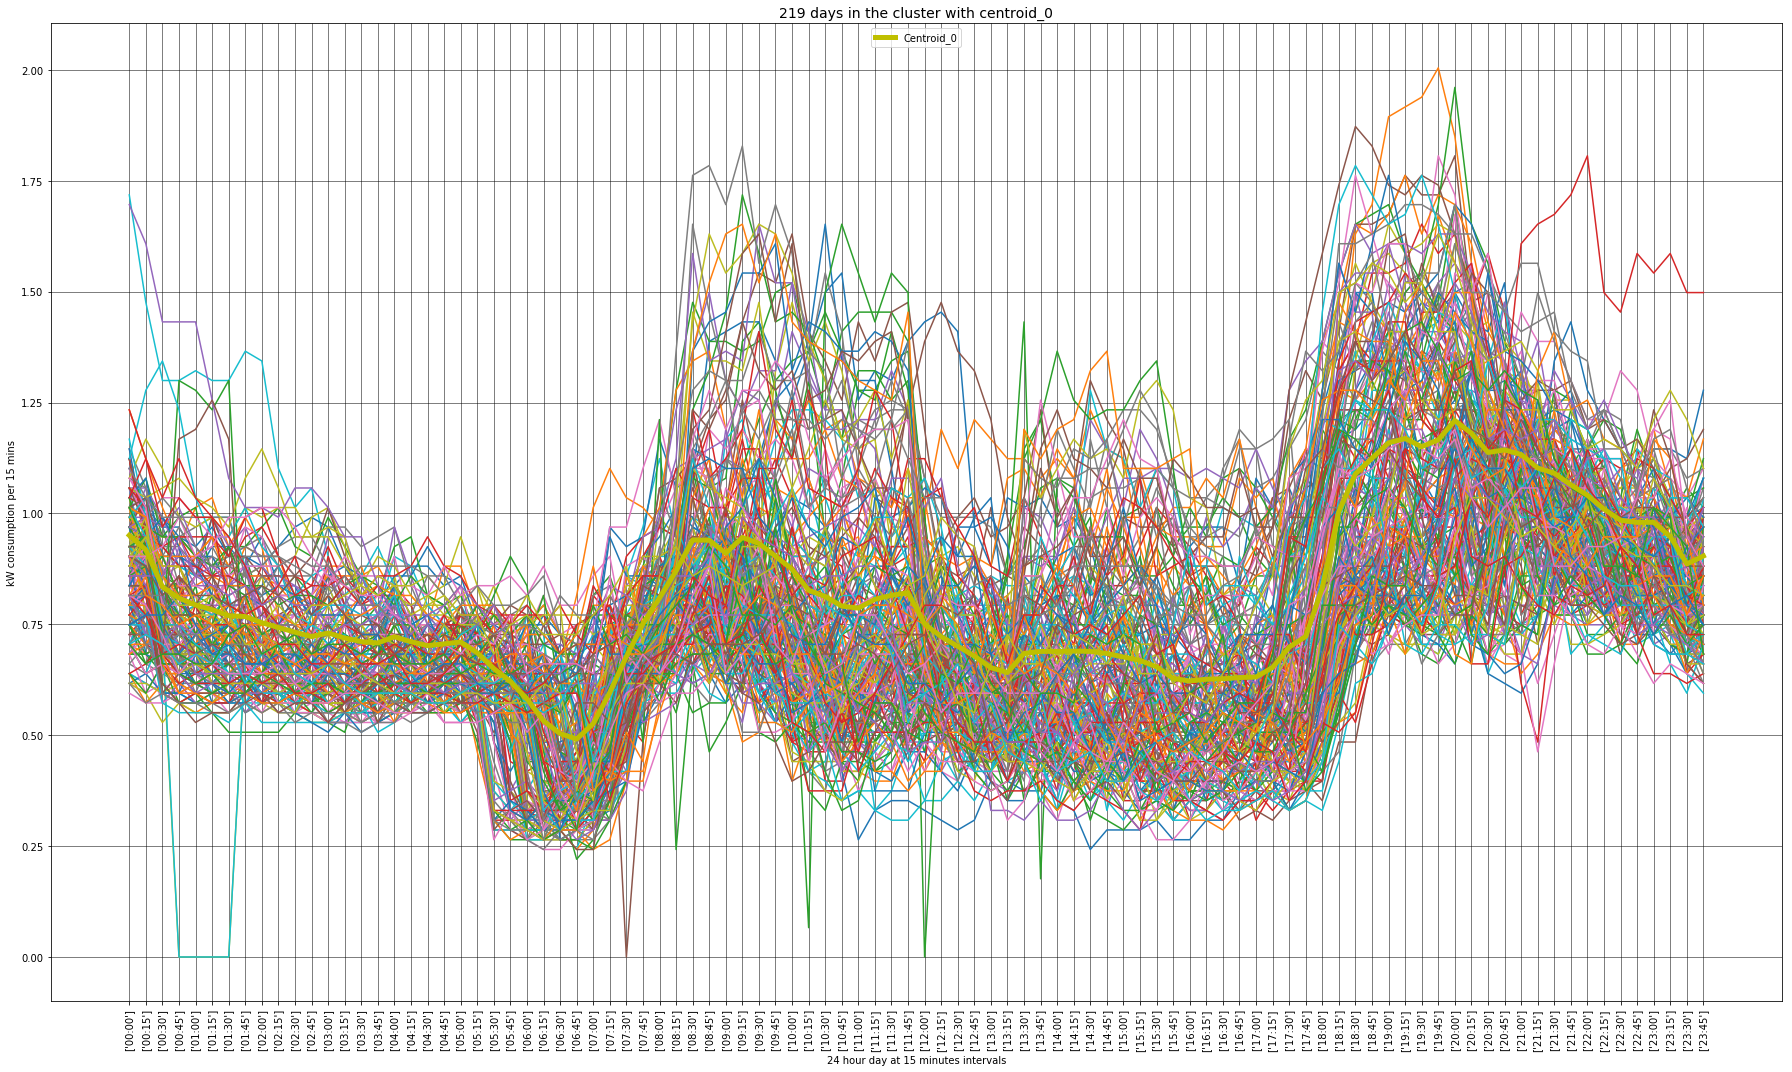

In [79]:
# TIME TO PLOT

# Time to graph

plt.figure(figsize=(25,15))

#plt.figure(figsize=(15,40))

x_axis = [i for i in range(96)]

plt.plot()

plt.subplot(1,1,1)
#plt.subplot(161)
plt.title("219 days in the cluster with centroid_0", fontsize=14)
for i in range(X_ordered_centroid_0.shape[0]):
    plt.plot(X_ordered_centroid_0[i])
plt.plot(centroids[0], linewidth = 5, c = 'y', label = "Centroid_0")
plt.xticks(x_axis, list(x_axis_time), rotation='vertical') # DO NOT DELETE
plt.xlabel("24 hour day at 15 minutes intervals")
plt.ylabel("kW consumption per 15 mins")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.legend(loc="upper center")

plt.show()

/home/isaac/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


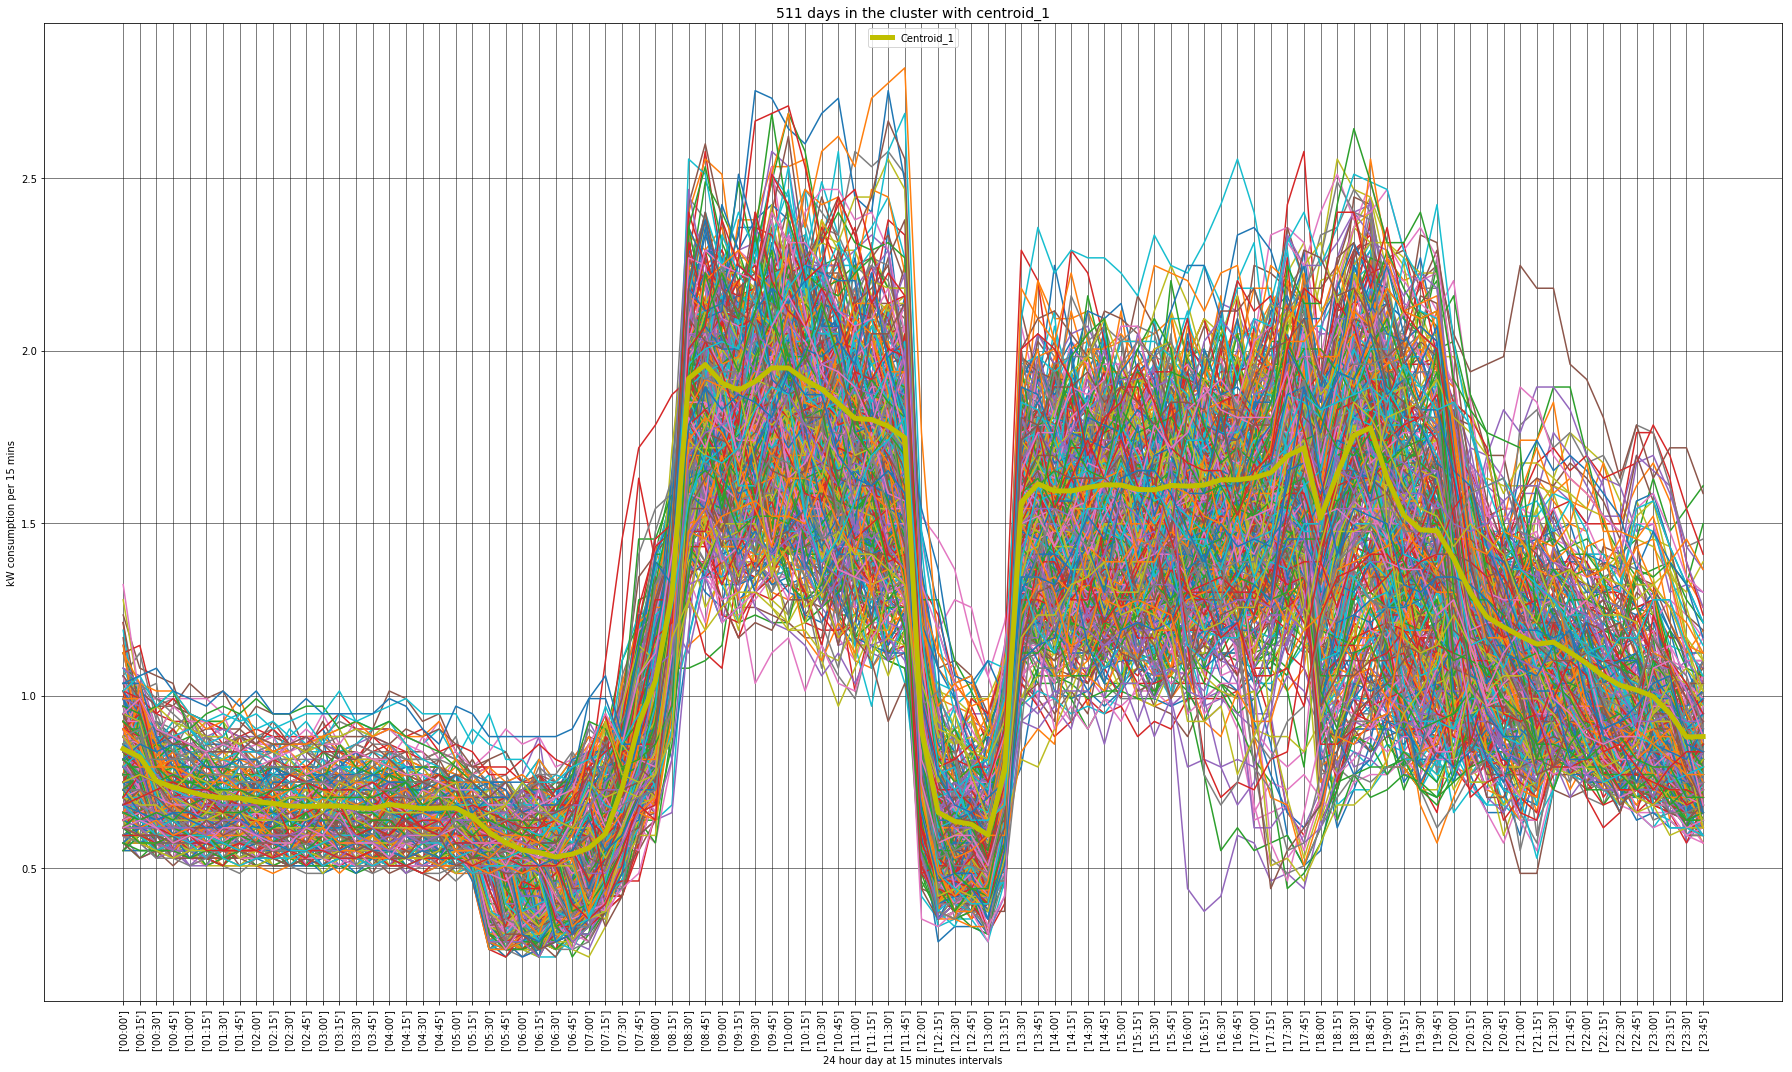

In [80]:
plt.figure(figsize=(25,15))

plt.plot()

plt.subplot(1,1,1)
#plt.subplot(162)
plt.title("511 days in the cluster with centroid_1", fontsize=14)
for i in range(X_ordered_centroid_1.shape[0]):
    plt.plot(X_ordered_centroid_1[i])
plt.plot(centroids[1], linewidth = 5, c = 'y', label = "Centroid_1")
plt.xticks(x_axis, list(x_axis_time), rotation='vertical')
plt.xlabel("24 hour day at 15 minutes intervals")
plt.ylabel("kW consumption per 15 mins")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.legend(loc="upper center")


plt.show()

In [81]:
# Hypothesis: cluster_0 is the weekend, cluster_1 is the workweek.
# So, given the hypothesis, we need to separate days into weekends and workweeks
# BRILLIANT!

# Get the days

from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

# Get the labels

kmeans_labels = kmeans.labels_ # numpy array containing labels between 0 and 5. Shape of the array is 730 by 1

kmeans_labels_bool = [not not x for x in kmeans_labels]
kmeans_labels_bool_array = np.array(kmeans_labels_bool)
# kmeans_labels_bool_array

# Now that we have converted the kmeans_labels to bool, time to get the days belonging to each cluster

from itertools import compress

#weekends = np.array(list(compress(daysyear, kmeans_labels_bool_array)))
workdays = np.array(list(compress(daysyear, kmeans_labels_bool_array)))
print(workdays)

# Why do some days in workdays include the sat? So, do daysyear start on a correct day?

# Time to get the weekends. To do this, we need to invert the values in kmeans_labels_bool_array so that
# False becomes True and True becomes False

weekend_kmeans_labels_bool_array = np.invert(kmeans_labels_bool_array)

weekends = np.array(list(compress(daysyear, weekend_kmeans_labels_bool_array)))
print(weekends)

['wed-2013-01-02' 'thu-2013-01-03' 'fri-2013-01-04' 'mon-2013-01-07'
 'tue-2013-01-08' 'wed-2013-01-09' 'thu-2013-01-10' 'fri-2013-01-11'
 'mon-2013-01-14' 'tue-2013-01-15' 'wed-2013-01-16' 'thu-2013-01-17'
 'fri-2013-01-18' 'mon-2013-01-21' 'tue-2013-01-22' 'wed-2013-01-23'
 'thu-2013-01-24' 'fri-2013-01-25' 'mon-2013-01-28' 'tue-2013-01-29'
 'wed-2013-01-30' 'thu-2013-01-31' 'fri-2013-02-01' 'mon-2013-02-04'
 'tue-2013-02-05' 'wed-2013-02-06' 'thu-2013-02-07' 'fri-2013-02-08'
 'mon-2013-02-11' 'wed-2013-02-13' 'thu-2013-02-14' 'fri-2013-02-15'
 'mon-2013-02-18' 'tue-2013-02-19' 'wed-2013-02-20' 'thu-2013-02-21'
 'fri-2013-02-22' 'mon-2013-02-25' 'tue-2013-02-26' 'wed-2013-02-27'
 'thu-2013-02-28' 'fri-2013-03-01' 'mon-2013-03-04' 'tue-2013-03-05'
 'wed-2013-03-06' 'thu-2013-03-07' 'fri-2013-03-08' 'mon-2013-03-11'
 'tue-2013-03-12' 'wed-2013-03-13' 'thu-2013-03-14' 'fri-2013-03-15'
 'mon-2013-03-18' 'tue-2013-03-19' 'wed-2013-03-20' 'thu-2013-03-21'
 'fri-2013-03-22' 'mon-2013-03-25'

#### Conclusion:

Cluster 0 is the electricity usage during the weekend (or days off).

Cluster 1 is the electricity usage during the weekdays (or work days)

Now, let's explain some anomalies in workdays and weekends.
- Why do we see weekends in workdays? - One of the answers to this is that the person was perhaps working overtime and thus needed to work on weekends.
- Why do we see workdays in weekends? - One of the answers to this is that the person needed to take days off for unbeknownst to us reasons.
- Another explanation is that KMeans did not label some of the data properly and thus this resulted in errors. Therefore, KMeans is bound to have errors.

Additionally, as suggested by Ashish/Konrad:

- Cluster 0 and Cluster 1 looks like the electricity usage during the workdays and statutory holidays and weekends. We can't have 219 days (Cluster 0) as weekends in a 2 years time frame, We have to factor the statutory holidays, which play a major in the usage pattern. 

- For example. in Portugal, 25th April is the Freedom day. 25th April 2014 was a Friday - So any other Friday will have a different usage compared to this statutory holiday.   

#### The following cell generates a list of all the days in the two years 2013-2014, which is helpful to answer part (b)

In [82]:
from datetime import date, timedelta

d1 = date(2013, 1, 1)  # start date
d2 = date(2014, 12, 31)  # end date
delta = d2 - d1         # timedelta
daysyear = []
D = {0:'mon', 1:'tue', 2:'wed', 3:'thu', 4:'fri', 5:'sat', 6:'sun'}
for i in range(delta.days + 1):
    daysyear.extend([D[(d1 + timedelta(days=i)).weekday()]+"-"+str(d1 + timedelta(days=i))])

In [83]:
daysyear_array = np.array(daysyear)
daysyear_array.shape

(730,)

#### The following cell shows you how to do the following: given a list L, and a list of booleans B (True, False), get the sublist of L that corresponds to the True values in B. For example if L=[1,2,3,4] and B=[False,True,True,False], then the results is [2,3]. This is also helpful for pard (b)

In [84]:
from itertools import compress
L = [1,2,3,4]
B = [False, True, True, False]
list(compress(L, B))

[2, 3]